In [3]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=4
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import numpy as np
from transformers import DataCollatorWithPadding

def tokenize_fn(batch):
  return tokenizer(batch["text"], truncation=True)

tokenized_ds = dataset.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [7]:
from evaluate import load

accuracy = load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)
  return accuracy.compute(predictions=preds, references=labels)

In [8]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
  output_dir="./results/as_is",
  per_device_eval_batch_size=64,
  do_train=False,
  do_eval=True,
  seed=42
)

trainer = Trainer(
  model=model,
  args=training_args,
  eval_dataset=tokenized_ds["test"],
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics
)

as_is_metrics = trainer.evaluate()
as_is_metrics

/tmp/ipython-input-529265999.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anmatyushkov (anmatyushkov-sdfsrefgesf) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.3984410762786865,
 'eval_model_preparation_time': 0.0059,
 'eval_accuracy': 0.24894736842105264,
 'eval_runtime': 27.5536,
 'eval_samples_per_second': 275.826,
 'eval_steps_per_second': 4.319}

In [9]:
model_full = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=4
)

training_args_full = TrainingArguments(
  output_dir="./results/full",
  eval_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  num_train_epochs=2,
  weight_decay=0.01,
  seed=42
)

trainer_full = Trainer(
  model=model_full,
  args=training_args_full,
  train_dataset=tokenized_ds["train"],
  eval_dataset=tokenized_ds["test"],
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics
)

trainer_full.train()
full_metrics = trainer_full.evaluate()
full_metrics

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1738817130.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.196700,0.181328,0.942237


{'eval_loss': 0.18132789433002472,
 'eval_accuracy': 0.9422368421052632,
 'eval_runtime': 27.113,
 'eval_samples_per_second': 280.308,
 'eval_steps_per_second': 4.389,
 'epoch': 1.0}

In [10]:
model_lp = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=4
)

for param in model_lp.base_model.parameters():
  param.requires_grad = False

training_args_lp = TrainingArguments(
  output_dir="./results/linear_probing",
  eval_strategy="epoch",
  learning_rate=1e-3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  num_train_epochs=2,
  seed=42
)

trainer_lp = Trainer(
  model=model_lp,
  args=training_args_lp,
  train_dataset=tokenized_ds["train"],
  eval_dataset=tokenized_ds["test"],
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics
)

trainer_lp.train()
lp_metrics = trainer_lp.evaluate()
lp_metrics

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3766093527.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lp = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.278300,0.262104,0.904868


{'eval_loss': 0.26210400462150574,
 'eval_accuracy': 0.9048684210526315,
 'eval_runtime': 26.7165,
 'eval_samples_per_second': 284.468,
 'eval_steps_per_second': 4.454,
 'epoch': 1.0}

In [11]:
from peft import LoraConfig, get_peft_model, TaskType

model_lora = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=4
)

lora_config = LoraConfig(
  task_type=TaskType.SEQ_CLS,
  r=8,
  lora_alpha=16,
  lora_dropout=0.1,
  target_modules=["q_lin", "v_lin"]
)

model_lora = get_peft_model(model_lora, lora_config)

training_args_lora = TrainingArguments(
  output_dir="./results/lora",
  eval_strategy="epoch",
  learning_rate=2e-4,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  num_train_epochs=2,
  seed=42
)

trainer_lora = Trainer(
  model=model_lora,
  args=training_args_lora,
  train_dataset=tokenized_ds["train"],
  eval_dataset=tokenized_ds["test"],
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics
)

trainer_lora.train()
lora_metrics = trainer_lora.evaluate()
lora_metrics

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1456175452.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.214400,0.203143,0.929868


{'eval_loss': 0.2031428962945938,
 'eval_accuracy': 0.9298684210526316,
 'eval_runtime': 27.9713,
 'eval_samples_per_second': 271.707,
 'eval_steps_per_second': 4.254,
 'epoch': 1.0}

In [12]:
def extract_history(trainer):
    logs = trainer.state.log_history

    train_loss = []
    eval_loss = []
    eval_acc = []
    steps = []

    for log in logs:
        if "loss" in log and "eval_loss" not in log:
            train_loss.append(log["loss"])
        if "eval_loss" in log:
            eval_loss.append(log["eval_loss"])
            eval_acc.append(log.get("eval_accuracy"))
            steps.append(log["epoch"])

    return {
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "eval_accuracy": eval_acc,
        "epochs": steps
    }

In [13]:
history_full = extract_history(trainer_full)
history_lp   = extract_history(trainer_lp)
history_lora = extract_history(trainer_lora)

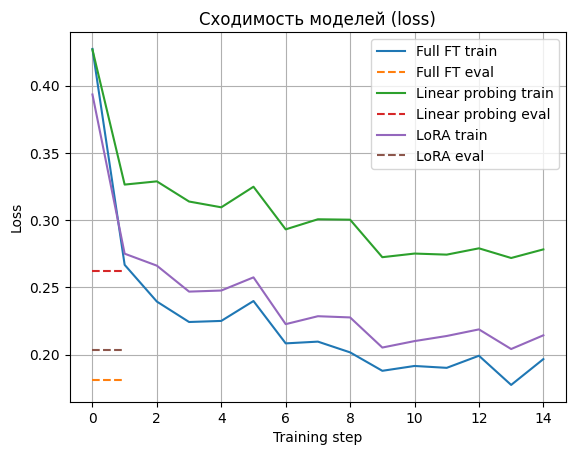

In [14]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(history_full["train_loss"], label="Full FT train")
plt.plot(history_full["eval_loss"], "--", label="Full FT eval")

plt.plot(history_lp["train_loss"], label="Linear probing train")
plt.plot(history_lp["eval_loss"], "--", label="Linear probing eval")

plt.plot(history_lora["train_loss"], label="LoRA train")
plt.plot(history_lora["eval_loss"], "--", label="LoRA eval")

plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Сходимость моделей (loss)")
plt.legend()
plt.grid(True)
plt.show()

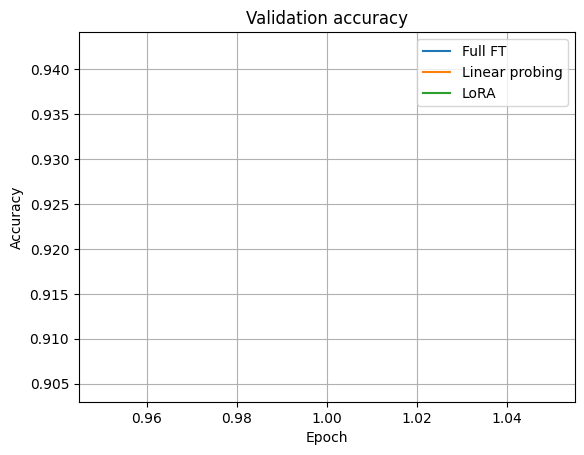

In [15]:
plt.figure()

plt.plot(history_full["epochs"], history_full["eval_accuracy"], label="Full FT")
plt.plot(history_lp["epochs"], history_lp["eval_accuracy"], label="Linear probing")
plt.plot(history_lora["epochs"], history_lora["eval_accuracy"], label="LoRA")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy")
plt.legend()
plt.grid(True)
plt.show()

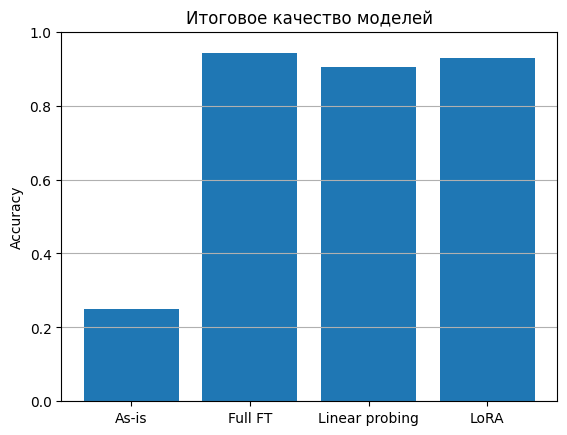

In [16]:
models = ["As-is", "Full FT", "Linear probing", "LoRA"]
accuracies = [
    as_is_metrics["eval_accuracy"],
    full_metrics["eval_accuracy"],
    lp_metrics["eval_accuracy"],
    lora_metrics["eval_accuracy"]
]

plt.figure()
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Итоговое качество моделей")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()